In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
train_method = 'uncued'

In [3]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm import tqdm
pd.set_option('display.max_columns', 500)
from functools import reduce
import scipy.stats

In [4]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig
SAVE_FIGS = True

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/general.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from cdcp.visualization.colors import colors as cdcp_colors

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [8]:
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [9]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]
birds_df = pd.DataFrame(birds, columns = ['bird', 'timestamp', 'sorter']).set_index('bird')

In [10]:
identifiers = ['spike_count', 'unit_location', 'single_unit_decoder_cue_analysis_equal_cues_train_passive']

In [11]:
all_unit_statistics_df= []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    
    unit_statistics_df_list = []
    for identifier in identifiers:
        unit_statistics_df = pd.read_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )
        unit_statistics_df_list.append(unit_statistics_df)
        
    print(bird, 'nrows per', [len(i) for i in unit_statistics_df_list])
    
    # combine dfs
    unit_statistics_df = reduce(lambda x, y: pd.merge(x, y, on = 'unit', how='outer'), unit_statistics_df_list)
    unit_statistics_df['bird'] = bird
    
    all_unit_statistics_df.append(unit_statistics_df)

unit_statistics_df = pd.concat(all_unit_statistics_df)

birds:  10%|█         | 1/10 [00:00<00:06,  1.43it/s]

B1597 nrows per [6750, 8711, 6750]
B1188 nrows per [510, 821, 510]
B1595 nrows per [242, 325, 242]
B1276 nrows per [46, 57, 46]
B1426 nrows per [93, 180, 93]


birds:  60%|██████    | 6/10 [00:01<00:00,  7.05it/s]

B1432 nrows per [2157, 2364, 2157]
B1170 nrows per [1281, 1693, 1281]
B1244 nrows per [141, 150, 141]


birds:  90%|█████████ | 9/10 [00:01<00:00,  5.93it/s]

B1593 nrows per [7714, 13260, 7714]


birds: 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

B1248 nrows per [8698, 13184, 8698]


In [12]:
# merge with categorical units
categorical_units_df = pd.read_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle')
categorical_units_df= categorical_units_df[categorical_units_df.categorical_unit == True]
unit_statistics_df_cat = pd.merge(unit_statistics_df, categorical_units_df, on = ['bird', 'unit'])
# subset categorical units
#unit_statistics_df_cat = unit_statistics_df_cat[unit_statistics_df_cat.categorical_unit == True]
unit_statistics_df = unit_statistics_df_cat
print(len(unit_statistics_df))

### merge with unit types
unit_type_df = pd.read_pickle(DATA_DIR / "unit_classes_01_23_22.pickle")
#unit_type_df = unit_type_df[["nuclei","AP","ML","DV","amplitude","template_amplitude","sr","fw","hw","bird","unit"]]
unit_statistics_df_ut = pd.merge(unit_statistics_df, unit_type_df, on = ['bird', 'unit'])
unit_statistics_df = unit_statistics_df_ut
print(len(unit_statistics_df))

6754
6754


In [13]:
unit_statistics_df = unit_statistics_df.sort_values(by=['n_active_trials'], ascending=False)

In [14]:
unit_statistics_df["bird_unit"] = ["_".join([row.bird, row.unit]) for idx, row in unit_statistics_df.iterrows()]

In [15]:
unit_statistics_df[:2]

,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,unit,hemisphere,labeled_region,estimated_nuclei,distance_to_estimated_nuclei,ML,AP,DV,AE_n_train,AE_n_valid,AE_n_invalid,AE_train_acc,AE_valid_acc,AE_invalid_acc,AE_train_confusion_matrix,AE_valid_confusion_matrix,AE_invalid_confusion_matrix,AF_n_train,AF_n_valid,AF_n_invalid,AF_train_acc,AF_valid_acc,AF_invalid_acc,AF_train_confusion_matrix,AF_valid_confusion_matrix,AF_invalid_confusion_matrix,BF_n_train,BF_n_valid,BF_n_invalid,BF_train_acc,BF_valid_acc,BF_invalid_acc,BF_train_confusion_matrix,BF_valid_confusion_matrix,BF_invalid_confusion_matrix,BE_n_train,BE_n_valid,BE_n_invalid,BE_train_acc,BE_valid_acc,BE_invalid_acc,BE_train_confusion_matrix,BE_valid_confusion_matrix,BE_invalid_confusion_matrix,CE_n_train,CE_n_valid,CE_n_invalid,CE_train_acc,CE_valid_acc,CE_invalid_acc,CE_train_confusion_matrix,CE_valid_confusion_matrix,CE_invalid_confusion_matrix,BG_n_train,BG_n_valid,BG_n_invalid,BG_train_acc,BG_valid_acc,BG_invalid_acc,BG_train_confusion_matrix,BG_valid_confusion_matrix,BG_invalid_confusion_matrix,AG_n_train,AG_n_valid,AG_n_invalid,AG_train_acc,AG_valid_acc,AG_invalid_acc,AG_train_confusion_matrix,AG_valid_confusion_matrix,AG_invalid_confusion_matrix,CF_n_train,CF_n_valid,CF_n_invalid,CF_train_acc,CF_valid_acc,CF_invalid_acc,CF_train_confusion_matrix,CF_valid_confusion_matrix,CF_invalid_confusion_matrix,CG_n_train,CG_n_valid,CG_n_invalid,CG_train_acc,CG_valid_acc,CG_invalid_acc,CG_train_confusion_matrix,CG_valid_confusion_matrix,CG_invalid_confusion_matrix,bird,categorical_unit,categoricality,fw,sr,unit_type,best_chan_templates,best_chan_templates_norm,amplitude,bird_unit
1185,135308,22462,2952,21969,7852,108288,27020,3782468,3428,NaN,NaN,NCL,494.54,2731.25,2420.0,-802.499502,24066,940,940,0.359761,0.303191,0.303191,"[[839, 275, 77, 81, 51, 59, 83, 12, 1, 0, 3, 6...","[[10, 6, 4, 2, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0...","[[13, 7, 1, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0...",8747,911,911,0.332343,0.264544,0.246981,"[[228, 125, 55, 50, 18, 30, 17, 6, 0, 4, 10, 7...","[[14, 10, 5, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, ...","[[8, 9, 8, 6, 1, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0,...",24137,900,900,0.3372,0.265556,0.314444,"[[422, 258, 93, 137, 70, 97, 64, 82, 39, 30, 3...","[[10, 11, 6, 3, 4, 16, 2, 4, 4, 2, 1, 1, 1, 2,...","[[9, 2, 5, 2, 8, 21, 10, 2, 4, 3, 0, 0, 0, 0, ...",8755,927,927,0.217818,0.15534,0.157497,"[[227, 111, 75, 53, 26, 12, 9, 3, 2, 3, 1, 2, ...","[[11, 1, 6, 2, 7, 3, 2, 0, 0, 0, 0, 1, 0, 2, 0...","[[16, 2, 3, 4, 2, 4, 2, 1, 0, 0, 1, 1, 1, 0, 0...",7946,226,226,0.252077,0.159292,0.123894,"[[294, 100, 42, 18, 7, 1, 2, 3, 3, 4, 8, 10, 5...","[[3, 7, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[1, 2, 4, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",7923,178,178,0.215322,0.196629,0.202247,"[[201, 56, 42, 42, 26, 29, 9, 19, 9, 19, 12, 4...","[[3, 3, 0, 2, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0,...","[[0, 5, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0,...",7969,204,204,0.297653,0.230392,0.245098,"[[255, 96, 43, 18, 9, 10, 6, 2, 6, 5, 8, 10, 6...","[[3, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0,...","[[6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,...",7906,154,154,0.411839,0.246753,0.363636,"[[299, 74, 49, 20, 3, 0, 0, 1, 5, 10, 8, 4, 5,...","[[1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7893,183,183,0.303307,0.180328,0.20765,"[[181, 70, 91, 29, 39, 9, 28, 9, 4, 2, 3, 1, 0...","[[5, 12, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...","[[4, 6, 5, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,...",B1597,True,0.499018,43.0,25.960996,1,"[14.0, 13.911411411411411, 13.822822822822824,...","[0.01709673880257429, 0.0169885548054323, 0.01...",-560.25,B1597_3428
188,62396,16809,1337,17917,5211,42386,20010,1519167,11670,NaN,NaN,Field_L,558.515,2317.25,2420.0,-722.499502,8077,897,897,0.269778,0.200669,0.214047,"[[188, 83, 21, 29, 26, 14, 16, 10, 11, 18, 19,...","[[12, 10, 1, 0, 1, 3, 1, 0, 2, 2, 2, 2, 1, 0

### Set rows to stims

In [16]:
interps = ['AE', 'AF', 'AG', 'BE', 'BF', 'BG',  'CE', 'CF', 'CG'] #['AE', 'AF', 'BE', 'BF']
types_ = ['valid', 'invalid', 'train']

In [17]:
acc_df_interp = pd.DataFrame(
    #index = np.arange(len(unit_statistics_df)*len(interps)),
    columns = ['interp', 'unit', 'bird'] + 
    [f'{type_}_n' for type_ in types_] +
    #[f'{type_}_acc' for type_ in types_] +
    [f'{type_}_confusion_matrix' for type_ in types_]

)
i = 0
n_skip = 0
for axi, (idx, row) in tqdm(enumerate(unit_statistics_df.iterrows()), total = len(unit_statistics_df)):
    for interp in interps:
        
        # only include interpolations where there are at least 1 sample for each cue / interp point
        skip = False
        for type_ in types_:
            if np.product(np.shape(row[f"{interp}_{type_}_confusion_matrix"])) != 256:
                n_skip+=1
                #print(n_skip, row.unit, interp)    
                #if row.unit == '8542':
                #    breakme
                skip=True
        if skip:
            continue
    
        #acc_df_interp.loc[i] = (
        acc_df_interp.loc[len(acc_df_interp)] = (
            [
                interp,
                row.bird_unit,
                row.bird,
            ] + 
    [row[f'{interp}_n_{type_}'] for type_ in types_] +
    #[row[f'{interp}_{type_}_acc'] for type_ in types_] +
    [row[f'{interp}_{type_}_confusion_matrix'] for type_ in types_]

        )
        i+=1

100%|██████████| 6754/6754 [00:27<00:00, 248.95it/s] 


In [18]:
acc_df_interp[:3]

,interp,unit,bird,valid_n,invalid_n,train_n,valid_confusion_matrix,invalid_confusion_matrix,train_confusion_matrix
0,AE,B1597_3428,B1597,940,940,24066,"[[10, 6, 4, 2, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0...","[[13, 7, 1, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0...","[[839, 275, 77, 81, 51, 59, 83, 12, 1, 0, 3, 6..."
1,AF,B1597_3428,B1597,911,911,8747,"[[14, 10, 5, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, ...","[[8, 9, 8, 6, 1, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0,...","[[228, 125, 55, 50, 18, 30, 17, 6, 0, 4, 10, 7..."
2,AG,B1597_3428,B1597,204,204,7969,"[[3, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0,...","[[6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,...","[[255, 96, 43, 18, 9, 10, 6, 2, 6, 5, 8, 10, 6..."


In [19]:
len(np.unique(acc_df_interp.unit))

2960

In [20]:
# only include interpolations where there are at least 1 sample for each cue / interp point
prop_units = len(np.unique(acc_df_interp.unit)) / len(unit_statistics_df)
print(f"prop units where sufficient data is available {prop_units}")

prop units where sufficient data is available 0.43825880959431446


### Attach unit info to each row

In [21]:
unit_type_dict = {row.bird_unit:row.unit_type for idx, row in unit_statistics_df[['unit_type', 'bird_unit']].iterrows()}

nuclei_dict = {row.bird_unit:row.estimated_nuclei for idx, row in unit_statistics_df[['estimated_nuclei', 'bird_unit']].iterrows()}

acc_df_interp['estimated_nuclei'] = [nuclei_dict[row.unit] for idx, row in acc_df_interp.iterrows()]

acc_df_interp['unit_type'] = [unit_type_dict[row.unit] for idx, row in acc_df_interp.iterrows()]

### Get metrics for each row

In [22]:
def confusion_matrix_to_y_and_pred(confusion_matrix):
    """
    Converts a confusion matrix to true y values and predicted values.
    
    Parameters:
    -----------
    confusion_matrix : numpy array
        The confusion matrix returned by sklearn's confusion_matrix function.
    
    Returns:
    --------
    y_true : numpy array
        The true y values.
    y_pred : numpy array
        The predicted values.
    """
    # Compute the number of samples.
    n_samples = confusion_matrix.sum()
    
    # Get the number of classes.
    n_classes = confusion_matrix.shape[0]
    
    # Compute indices for the true y values and predicted values.
    y_true_idx = np.repeat(np.arange(n_classes), n_samples // n_classes)
    y_pred_idx = np.argmax(confusion_matrix, axis=1)
    y_pred_idx = np.tile(y_pred_idx, n_samples // n_classes)
    
    # Use advanced indexing to get the true y values and predicted values.
    y_true = y_true_idx[confusion_matrix.flatten().cumsum() - 1]
    y_pred = y_pred_idx[confusion_matrix.flatten().cumsum() - 1]
    
    return y_true, y_pred

In [23]:
row = acc_df_interp.iloc[0]

In [24]:
r2_dict = dict(list({f"{type_}_r2": [] for type_ in types_}.items()) + list({f"{type_}_p": [] for type_ in types_}.items()))
for idx, row in tqdm(acc_df_interp.iterrows(),total=len(acc_df_interp)):
    for type_ in types_:
        y = np.concatenate([np.repeat(ii, np.sum(i)) for ii, i in enumerate(row[f"{type_}_confusion_matrix"])])
        y_pred = np.concatenate([np.repeat(np.arange(16), i) for i in row[f"{type_}_confusion_matrix"]])
        r2, p = scipy.stats.pearsonr(y, y_pred)
        r2_dict[f"{type_}_r2"].append(r2)
        r2_dict[f"{type_}_p"].append(p)

100%|██████████| 7783/7783 [00:33<00:00, 232.88it/s]


In [25]:
for type_ in types_:
    acc_df_interp[f"r2_{type_}"] = r2_dict[f"{type_}_r2"]
    acc_df_interp[f"p_{type_}"] = r2_dict[f"{type_}_p"]

In [26]:
acc_df_interp["acc_train"] = [
    np.sum(np.diag(row.train_confusion_matrix)) / np.sum(row.train_confusion_matrix)
    for idx, row in acc_df_interp.iterrows()
]
acc_df_interp["acc_valid"] = [
    np.sum(np.diag(row.valid_confusion_matrix)) / np.sum(row.valid_confusion_matrix)
    for idx, row in acc_df_interp.iterrows()
]
acc_df_interp["acc_invalid"] = [
    np.sum(np.diag(row.invalid_confusion_matrix)) / np.sum(row.invalid_confusion_matrix)
    for idx, row in acc_df_interp.iterrows()
]

In [27]:
acc_df_interp["acc_test"] = [
    (np.sum(np.diag(row.invalid_confusion_matrix))+np.sum(np.diag(row.valid_confusion_matrix))) / (np.sum(row.invalid_confusion_matrix) +np.sum(row.valid_confusion_matrix))
    for idx, row in acc_df_interp.iterrows()
]

In [28]:
acc_df_interp["acc_valid_category"] = [
    (
        np.sum(row.valid_confusion_matrix[:8, :8])
        + np.sum(row.valid_confusion_matrix[8:, 8:])
    )
    / np.sum(np.sum(row.valid_confusion_matrix, axis=1))
    for idx, row in acc_df_interp.iterrows()
]

acc_df_interp["acc_invalid_category"] = [
    (
        np.sum(row.invalid_confusion_matrix[:8, :8])
        + np.sum(row.valid_confusion_matrix[8:, 8:])
    )
    / np.sum(np.sum(row.invalid_confusion_matrix, axis=1))
    for idx, row in acc_df_interp.iterrows()
]

In [29]:
acc_df_interp["acc_test_category"] = [
    (
        np.sum(row.invalid_confusion_matrix[:8, :8])
        + np.sum(row.valid_confusion_matrix[8:, 8:])
        + np.sum(row.valid_confusion_matrix[:8, :8])
        + np.sum(row.valid_confusion_matrix[8:, 8:])
        
    )
    / (np.sum(row.invalid_confusion_matrix)+np.sum(row.valid_confusion_matrix))
    for idx, row in acc_df_interp.iterrows()
]

In [30]:
# only include interpolations where there are at least 1 sample for each cue / interp point
prop_units = len(np.unique(acc_df_interp.unit)) / len(unit_statistics_df)
print(f"prop units where sufficient data is available {prop_units}")

prop units where sufficient data is available 0.43825880959431446


In [31]:
acc_df_interp[:3]

,interp,unit,bird,valid_n,invalid_n,train_n,valid_confusion_matrix,invalid_confusion_matrix,train_confusion_matrix,estimated_nuclei,unit_type,r2_valid,p_valid,r2_invalid,p_invalid,r2_train,p_train,acc_train,acc_valid,acc_invalid,acc_test,acc_valid_category,acc_invalid_category,acc_test_category
0,AE,B1597_3428,B1597,940,940,24066,"[[10, 6, 4, 2, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0...","[[13, 7, 1, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0...","[[839, 275, 77, 81, 51, 59, 83, 12, 1, 0, 3, 6...",NCL,1,0.806053,6.910242e-216,0.746411,4.431344e-168,0.836170,0.0,0.359761,0.303191,0.303191,0.303191,0.889362,0.891489,0.890426
1,AF,B1597_3428,B1597,911,911,8747,"[[14, 10, 5, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, ...","[[8, 9, 8, 6, 1, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0,...","[[228, 125, 55, 50, 18, 30, 17, 6, 0, 4, 10, 7...",NCL,1,0.703210,8.211663e-137,0.734655,2.513056e-155,0.822069,0.0,0.332343,0.264544,0.246981,0.255763,0.796926,0.818880,0.807903
2,AG,B1597_3428,B1597,204,204,7969,"[[3, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0,...","[[6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,...","[[255, 96, 43, 18, 9, 10, 6, 2, 6, 5, 8, 10, 6...",NCL,1,0.689589,3.975288e-30,0.735971,4.578739e-36,0.721638,0.0,0.297653,0.230392,0.245098,0.237745,0.838235,0.843137,0.840686


In [32]:
len(acc_df_interp.unit.unique())

2960

### Plot averages

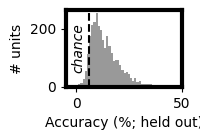

In [33]:
acc_measure = 'acc_test'
#mean_unit_acc = acc_df_interp.acc_test_category.values
mean_unit_acc = acc_df_interp[['unit',acc_measure]].groupby('unit').mean()[acc_measure].values
fig, ax = plt.subplots(figsize=(1.5,1))
ax.hist(mean_unit_acc * 100, bins=np.linspace(0,50,50), color = '#999999');
ax.axvline((1/16)* 100, color = 'k', ls='dashed')
ax.set_xlabel('Accuracy (%; held out)',fontsize=10)
ax.set_ylabel('# units', fontsize=10)
ax.text(0.05, 0.5, 'chance', rotation=90, va='center', ha='left', fontstyle='italic', transform=ax.transAxes)
ax.set_xlim([-5,50])
[i.set_linewidth(3) for i in ax.spines.values()]

if SAVE_FIGS:
    ensure_dir(FIGURE_DIR / 'decoder' / train_method)
    save_fig(FIGURE_DIR / 'decoder'/ train_method / 'acc-stim', save_pdf=True)
    plt.show()

In [34]:
mean_unit_acc

array([0.08262712, 0.08839779, 0.10212766, ..., 0.13642849, 0.09212626,
       0.06590233])

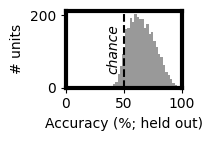

In [35]:
acc_measure = 'acc_test_category'
#mean_unit_acc = acc_df_interp.acc_test_category.values
mean_unit_acc = acc_df_interp[['unit',acc_measure]].groupby('unit').mean()[acc_measure].values
fig, ax = plt.subplots(figsize=(1.5,1))
ax.hist(mean_unit_acc * 100, bins=np.linspace(0,100,50), color = '#999999');
ax.axvline(50, color = 'k', ls='dashed')
ax.set_xlabel('Accuracy (%; held out)',fontsize=10)
ax.set_ylabel('# units', fontsize=10)
ax.text(0.35, 0.5, 'chance', rotation=90, va='center', ha='left', fontstyle='italic', transform=ax.transAxes)
ax.set_xlim([0,100])
[i.set_linewidth(3) for i in ax.spines.values()]

if SAVE_FIGS:
    ensure_dir(FIGURE_DIR / 'decoder')
    save_fig(FIGURE_DIR / 'decoder' / train_method/ 'acc-cat', save_pdf=True)
    plt.show()

##### Confusion matrix

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

In [37]:
def zscore(x):
    return (x - np.mean(x))/np.std(x)

def norm_confusion_matrix(c):
    #return zscore((c.T / c.astype(np.float).sum(axis=1)).T)
    return (c.T / c.astype(np.float).sum(axis=1)).T

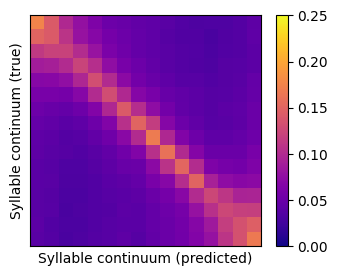

In [38]:
fig, ax = plt.subplots(figsize=(4,3))
cms = np.stack(
    acc_df_interp.valid_confusion_matrix.values + acc_df_interp.invalid_confusion_matrix.values
)
cms = [norm_confusion_matrix(i) for i in cms]
mean_cm = np.nanmean(
    cms,
    axis=0,
)
im = ax.matshow(mean_cm, cmap = 'plasma', vmin=0, vmax=0.25)
ax.set_ylabel('Syllable continuum (true)')
ax.set_xlabel('Syllable continuum (predicted)')
fig.colorbar(im, ax=ax)
ax.set_xticks([])
ax.set_yticks([])


if SAVE_FIGS:
    ensure_dir(FIGURE_DIR / 'decoder')
    save_fig(FIGURE_DIR / 'decoder' / train_method/ 'avg_confusion_matrix', save_pdf=True)
    plt.show()

### Plot acc for each category

### Stimulus

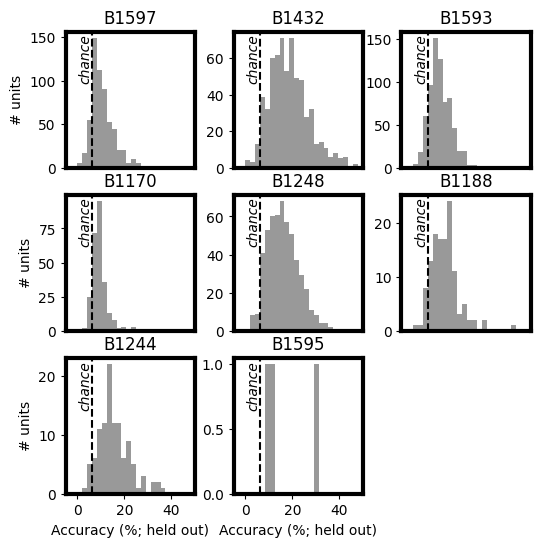

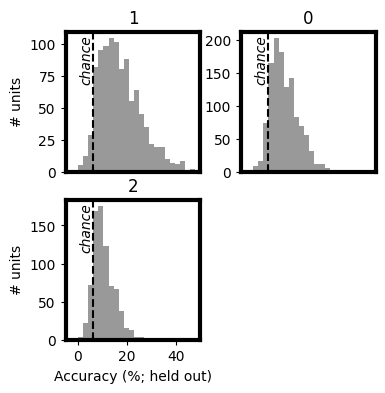

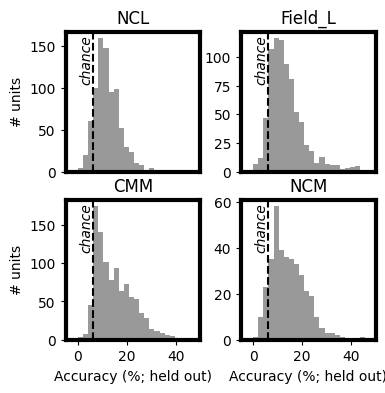

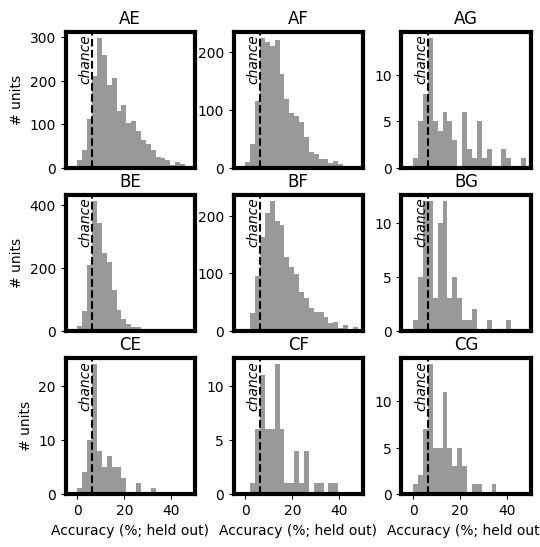

In [39]:
acc_measure = 'acc_test'
for feature in ['bird', "unit_type", 'estimated_nuclei', 'interp']:
    feats =  acc_df_interp[feature].unique()

    n_feats = len(feats)

    if n_feats in [3,4]:
        ncols = 2
        nrows = 2
    else:
        nrows = 3
        ncols = 3

    fig, axs = plt.subplots(ncols = ncols, nrows=nrows, figsize=(ncols*2,nrows*2))
    fig.subplots_adjust(wspace=0.3)

    for axi, feat in enumerate(feats):
        ax = axs.flatten()[axi]
        df = acc_df_interp[acc_df_interp[feature] == feat]
        mean_unit_acc = df[['unit',acc_measure]].groupby('unit').mean()[acc_measure].values
        ax.hist(mean_unit_acc * 100, bins=np.linspace(0,50,25), color = '#999999');
        ax.axvline((1/16)* 100, color = 'k', ls='dashed')
        ax.set_xticks([])

        if axi >= (ncols * nrows) -nrows:
            ax.set_xlabel('Accuracy (%; held out)',fontsize=10)
            ax.set_xticks([0, 20, 40])

        if axi % ncols == 0:
            ax.set_ylabel('# units', fontsize=10)
        ax.text(0.1, 0.8, 'chance', rotation=90, va='center', ha='left', fontstyle='italic', transform=ax.transAxes)
        ax.set_title(feat)
        ax.set_xlim([-5,50])
        [i.set_linewidth(3) for i in ax.spines.values()]

        
    for axi in range(axi+1, ncols*nrows):
        axs.flatten()[axi].axis('off')
    if SAVE_FIGS:
        ensure_dir(FIGURE_DIR / 'decoder')
        save_fig(FIGURE_DIR / 'decoder'/ train_method / f'{feature}_acc-cue', save_pdf=True)
    plt.show()

#### category

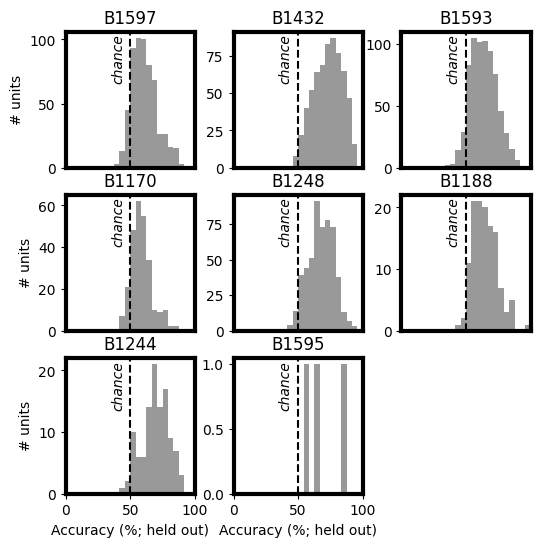

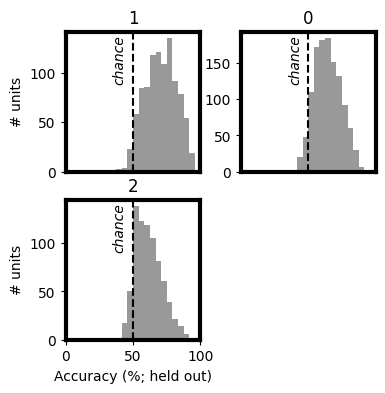

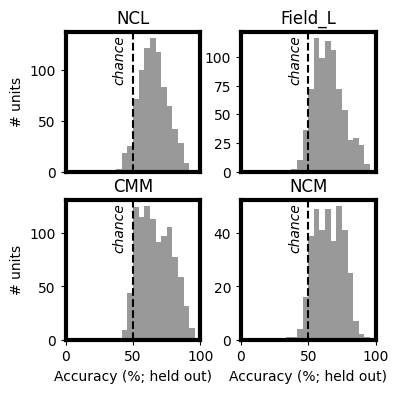

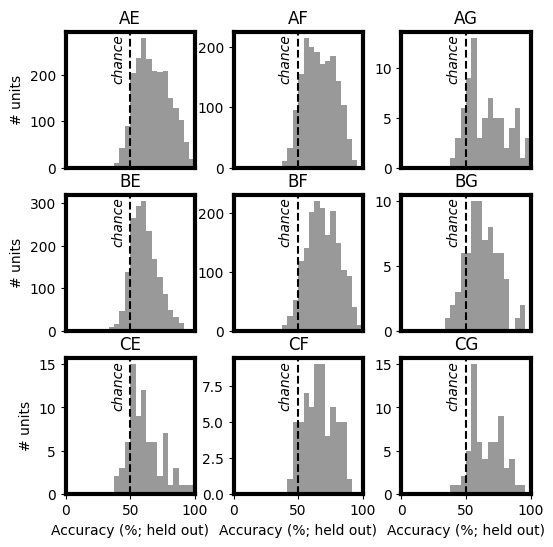

In [40]:
acc_measure = 'acc_test_category'
for feature in ['bird', "unit_type", 'estimated_nuclei', 'interp']:
    feats =  acc_df_interp[feature].unique()

    n_feats = len(feats)

    if n_feats in [3,4]:
        ncols = 2
        nrows = 2
    else:
        nrows = 3
        ncols = 3

    fig, axs = plt.subplots(ncols = ncols, nrows=nrows, figsize=(ncols*2,nrows*2))
    fig.subplots_adjust(wspace=0.3)

    for axi, feat in enumerate(feats):
        ax = axs.flatten()[axi]
        df = acc_df_interp[acc_df_interp[feature] == feat]
        mean_unit_acc = df[['unit',acc_measure]].groupby('unit').mean()[acc_measure].values
        ax.hist(mean_unit_acc * 100, bins=np.linspace(0,100,25), color = '#999999');
        ax.axvline(50, color = 'k', ls='dashed')
        ax.set_xticks([])

        if axi >= (ncols * nrows) -nrows:
            ax.set_xlabel('Accuracy (%; held out)',fontsize=10)
            ax.set_xticks([0, 50, 100])

        if axi % ncols == 0:
            ax.set_ylabel('# units', fontsize=10)
        ax.text(0.35, 0.8, 'chance', rotation=90, va='center', ha='left', fontstyle='italic', transform=ax.transAxes)
        ax.set_title(feat)
        ax.set_xlim([0,100])
        [i.set_linewidth(3) for i in ax.spines.values()]

        
    for axi in range(axi+1, ncols*nrows):
        axs.flatten()[axi].axis('off')
    if SAVE_FIGS:
        ensure_dir(FIGURE_DIR / 'decoder')
        save_fig(FIGURE_DIR / 'decoder' / train_method/ f'{feature}_acc-category', save_pdf=True)
    plt.show()

### Subset non-predictive units

In [41]:
pre_mask_n_units = len(np.unique(acc_df_interp.unit))
pre_mask_n_units

2960

In [42]:
acc_df_interp = acc_df_interp[
    (acc_df_interp.r2_valid.values > 0) & 
    (acc_df_interp.p_valid.values < 0.01)    
]

In [43]:
post_mask_n_units = len(np.unique(acc_df_interp.unit))
post_mask_n_units

2027

In [44]:
# only include interpolations where there are at least 1 sample for each cue / interp point
prop_neurons = post_mask_n_units / pre_mask_n_units
print(f"prop neurons where model decodes syllable above chance {prop_neurons}")

prop neurons where model decodes syllable above chance 0.6847972972972973


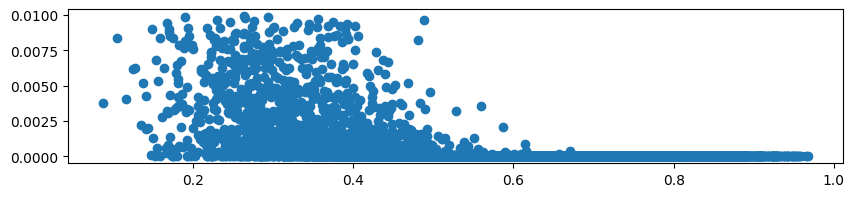

In [45]:
fig, ax = plt.subplots(figsize=(10,2))
ax.scatter(
    acc_df_interp.r2_valid.values,
    acc_df_interp.p_valid.values,
           )

## Test whether valid outpredicts invalid

In [46]:
acc_df_interp[:3]

,interp,unit,bird,valid_n,invalid_n,train_n,valid_confusion_matrix,invalid_confusion_matrix,train_confusion_matrix,estimated_nuclei,unit_type,r2_valid,p_valid,r2_invalid,p_invalid,r2_train,p_train,acc_train,acc_valid,acc_invalid,acc_test,acc_valid_category,acc_invalid_category,acc_test_category
0,AE,B1597_3428,B1597,940,940,24066,"[[10, 6, 4, 2, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0...","[[13, 7, 1, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0...","[[839, 275, 77, 81, 51, 59, 83, 12, 1, 0, 3, 6...",NCL,1,0.806053,6.910242e-216,0.746411,4.431344e-168,0.836170,0.0,0.359761,0.303191,0.303191,0.303191,0.889362,0.891489,0.890426
1,AF,B1597_3428,B1597,911,911,8747,"[[14, 10, 5, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, ...","[[8, 9, 8, 6, 1, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0,...","[[228, 125, 55, 50, 18, 30, 17, 6, 0, 4, 10, 7...",NCL,1,0.703210,8.211663e-137,0.734655,2.513056e-155,0.822069,0.0,0.332343,0.264544,0.246981,0.255763,0.796926,0.818880,0.807903
2,AG,B1597_3428,B1597,204,204,7969,"[[3, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0,...","[[6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,...","[[255, 96, 43, 18, 9, 10, 6, 2, 6, 5, 8, 10, 6...",NCL,1,0.689589,3.975288e-30,0.735971,4.578739e-36,0.721638,0.0,0.297653,0.230392,0.245098,0.237745,0.838235,0.843137,0.840686


### Test whether more units than chance have valid outpredicting invalid

##### Category

In [47]:
cue_valid_outpredicts_invalid_categorical = (
    acc_df_interp["acc_valid_category"].values
    > acc_df_interp["acc_invalid_category"].values
)

In [48]:
np.mean(cue_valid_outpredicts_invalid_categorical)

0.4558342420937841

In [49]:
# test whether the proportion 
scipy.stats.binomtest(
    np.sum(cue_valid_outpredicts_invalid_categorical),
    n=len(cue_valid_outpredicts_invalid_categorical),
    p=0.5,
)

BinomTestResult(k=2090, n=4585, alternative='two-sided', statistic=0.4558342420937841, pvalue=2.3703100264769027e-09)

##### Stim

In [50]:
cue_valid_outpredicts_invalid = np.array(acc_df_interp.acc_valid.values) > np.array(
    acc_df_interp.acc_invalid.values
)

In [51]:
np.mean(cue_valid_outpredicts_invalid)

0.47546346782988

In [52]:
# test whether the proportion 
scipy.stats.binomtest(
    np.sum(cue_valid_outpredicts_invalid),
    n=len(cue_valid_outpredicts_invalid),
    p=0.5,
)

BinomTestResult(k=2180, n=4585, alternative='two-sided', statistic=0.47546346782988, pvalue=0.000937314750901723)

### Test whether the prediction accuracy for valid is greater than invalid

##### Category

In [53]:
scipy.stats.ttest_rel(
    acc_df_interp["acc_valid_category"].values,
    acc_df_interp["acc_invalid_category"].values,
)

TtestResult(statistic=1.9169653241566849, pvalue=0.05530443448132609, df=4584)

##### Stim

In [54]:
scipy.stats.ttest_rel(
    acc_df_interp["acc_valid"].values,
    acc_df_interp["acc_invalid"].values,
)

TtestResult(statistic=1.126643385240233, pvalue=0.2599522623580633, df=4584)

### Plot difference 

In [55]:
mean = np.mean(acc_df_interp["acc_valid"].values - acc_df_interp["acc_invalid"].values)
sem = np.std(
    acc_df_interp["acc_valid"].values - acc_df_interp["acc_invalid"].values
) / np.sqrt(len(acc_df_interp))

In [56]:
mean

0.0009331447138202511

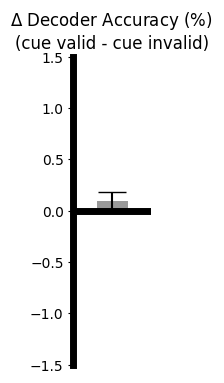

In [57]:
fig, ax = plt.subplots(figsize=(1,4))
ax.bar(0, mean*100, yerr=sem*100, capsize=10, color='#999999')
ax.set_xlim([-1,1])
ax.set_ylim([-1.5,1.5])
ax.axhline(0, color = 'k', lw=5)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_title('$\Delta$ Decoder Accuracy (%) \n(cue valid - cue invalid)');

[i.set_linewidth(0) for i in ax.spines.values()]
ax.spines['left'].set_linewidth(5)

if SAVE_FIGS:
    ensure_dir(FIGURE_DIR / 'decoder')
    save_fig(FIGURE_DIR / 'decoder' / train_method/ f'delta-acc-stim', save_pdf=True)
plt.show()

In [58]:
mean = np.mean(acc_df_interp["acc_valid_category"].values - acc_df_interp["acc_invalid_category"].values)
sem = np.std(
    acc_df_interp["acc_valid_category"].values - acc_df_interp["acc_invalid_category"].values
) / np.sqrt(len(acc_df_interp))

In [59]:
mean

0.0013618814620777941

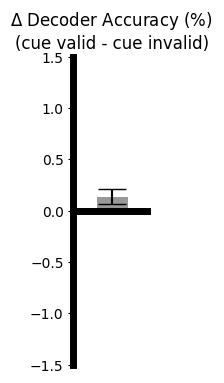

In [60]:
fig, ax = plt.subplots(figsize=(1,4))
ax.bar(0, mean*100, yerr=sem*100, capsize=10, color='#999999')
ax.set_xlim([-1,1])
ax.set_ylim([-1.5,1.5])
ax.axhline(0, color = 'k', lw=5)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_title('$\Delta$ Decoder Accuracy (%) \n(cue valid - cue invalid)');

[i.set_linewidth(0) for i in ax.spines.values()]
ax.spines['left'].set_linewidth(5)

if SAVE_FIGS:
    ensure_dir(FIGURE_DIR / 'decoder')
    save_fig(FIGURE_DIR / 'decoder'/ train_method / f'delta-acc-category', save_pdf=True)
plt.show()

### Plot confusion matrix for each category

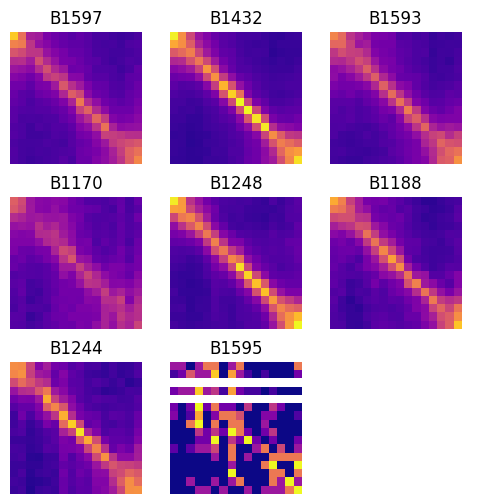

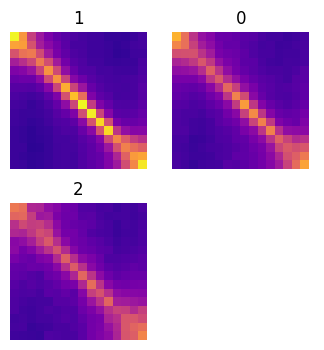

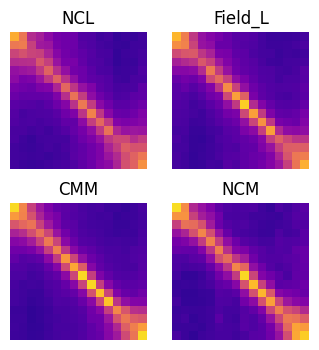

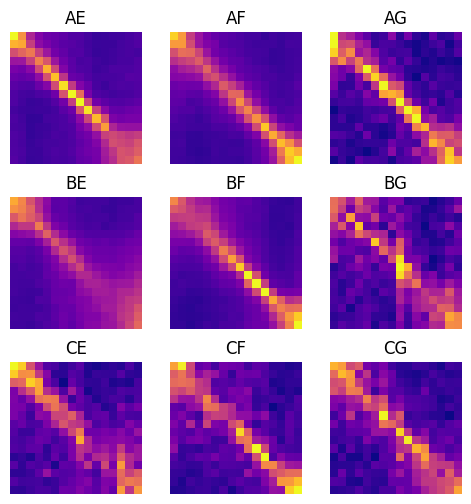

In [61]:
acc_measure = "acc_test"
for feature in ["bird", "unit_type", "estimated_nuclei", "interp"]:
    feats = acc_df_interp[feature].unique()

    n_feats = len(feats)

    if n_feats in [3, 4]:
        ncols = 2
        nrows = 2
    else:
        nrows = 3
        ncols = 3

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 2, nrows * 2))
    fig.subplots_adjust(wspace=0.1, hspace=0.25)

    for axi, feat in enumerate(feats):
        ax = axs.flatten()[axi]
        df = acc_df_interp[acc_df_interp[feature] == feat]
        cms = np.stack(
            df.valid_confusion_matrix.values + df.invalid_confusion_matrix.values
        )
        cms = [norm_confusion_matrix(i) for i in cms]
        mean_cm = np.nanmean(
            cms,
            axis=0,
        )
        ax.matshow(mean_cm, cmap="plasma", vmin=0, vmax=0.25)
        ax.axis("off")
        ax.set_title(feat, y=1)
    for axi in range(axi + 1, ncols * nrows):
        axs.flatten()[axi].axis("off")
    if SAVE_FIGS:
        ensure_dir(FIGURE_DIR / "decoder")
        save_fig(FIGURE_DIR / "decoder" / train_method/ f"{feature}_confusion-matrix", save_pdf=True)
    plt.show()

### Plot acc shift for each category

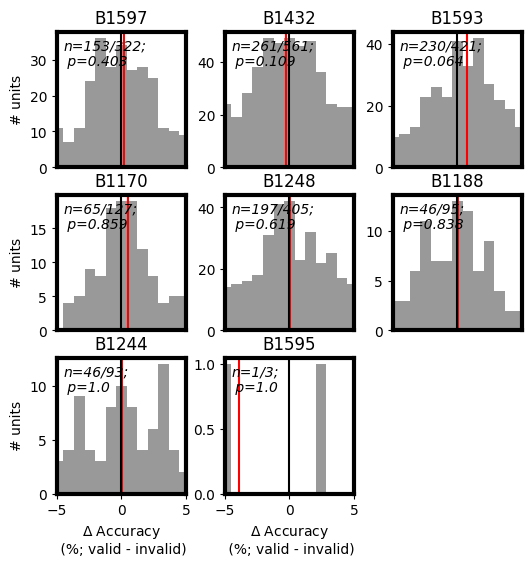

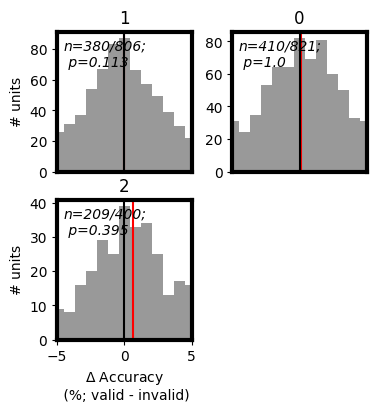

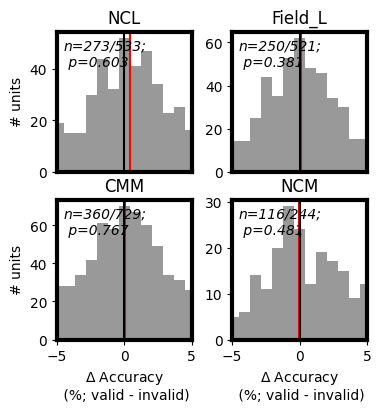

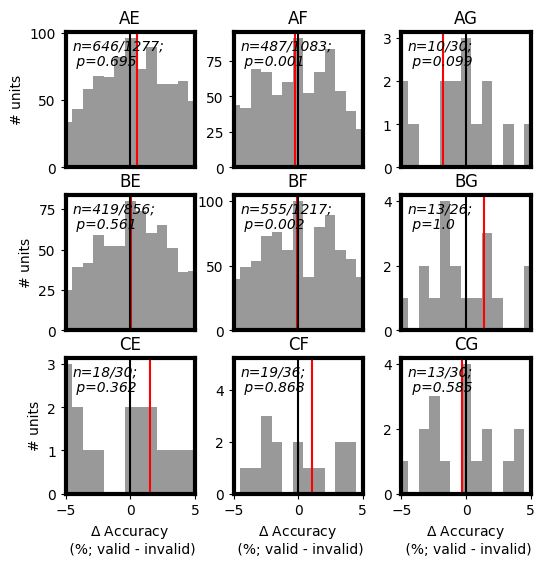

In [62]:
for feature in ['bird', "unit_type", 'estimated_nuclei', 'interp']:
    feats =  acc_df_interp[feature].unique()

    n_feats = len(feats)

    if n_feats in [3,4]:
        ncols = 2
        nrows = 2
    else:
        nrows = 3
        ncols = 3

    fig, axs = plt.subplots(ncols = ncols, nrows=nrows, figsize=(ncols*2,nrows*2))
    fig.subplots_adjust(wspace=0.3)

    for axi, feat in enumerate(feats):
        ax = axs.flatten()[axi]
        df = acc_df_interp[acc_df_interp[feature] == feat]
        if len(df) == 0:
            continue
        

        # get the mean valid vs invalid (across interpolations) for each unit
        df_unit = (
            df[["unit", "acc_valid", "acc_invalid"]]
            .groupby(by="unit")
            .mean()
        )

        # determine the units where valid outpredicts invalid
        cue_valid_outpredicts_invalid = (
            df_unit.acc_valid > df_unit.acc_invalid
        )

        # test whether the proportion 
        result = scipy.stats.binomtest(
            np.sum(cue_valid_outpredicts_invalid),
            n=len(cue_valid_outpredicts_invalid),
            p=0.5,
        )
        #print(result)

        cue_valid_invalid_diff = df_unit.acc_valid.values - df_unit.acc_invalid.values
        ax.hist(cue_valid_invalid_diff*100, bins=np.linspace(-20, 20, 50), color='#999999');
        ax.axvline(np.mean(cue_valid_invalid_diff)*100, color = 'red')
        ax.axvline(0, color = 'k')
        ax.set_xlim([-5, 5])
        ax.set_xticks([])
        if axi >= (ncols * nrows) -nrows:
            ax.set_xlabel('$\Delta$ Accuracy \n (%; valid - invalid)',fontsize=10)
            
            ax.set_xticks([-5, 0, 5])

        if axi % ncols == 0:
            ax.set_ylabel('# units', fontsize=10)
        ax.set_title(feat)
        [i.set_linewidth(3) for i in ax.spines.values()]
        
        ax.text(0.05, 0.95, f"n={result.k}/{result.n};\n p={round(result.pvalue, 3)}", va='top', ha='left', fontstyle='italic', transform=ax.transAxes)
        
        
        #break
        
    for axi in range(axi+1, ncols*nrows):
        axs.flatten()[axi].axis('off')
    if SAVE_FIGS:
        ensure_dir(FIGURE_DIR / 'decoder')
        save_fig(FIGURE_DIR / 'decoder'/ train_method/ f'{feature}_delta-acc', save_pdf=True)
    plt.show()    #break